In [4]:
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('max_columns', None)

# 데이터 준비

In [5]:
df = pd.read_csv("my_data/naver_finance/2016_12.csv")

In [6]:
df.head()

,ticker,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2
0,AK홀딩스,29218.310,7.313,4.563,1333.223,12.193,5.091,15.515,5436.413,48112.402,220556.160,10.301,1.164,0.254,56000.000,68500.000
1,BGF,860.773,9.315,214.481,1846.192,21.624,10.433,8.015,3703.577,18648.623,1737.263,22.757,4.519,48.514,42140.000,15250.000
2,BNK금융지주,49126.760,14.499,10.546,5181.144,7.919,0.564,nan,1568.237,20810.660,15358.993,5.535,0.417,0.565,8680.000,9420.000
3,BYC,2118.576,7.625,8.281,175.433,4.543,2.463,10.748,20872.312,471887.000,252211.450,19.020,0.841,1.574,397000.000,306000.000
4,CJ,239541.970,5.230,2.379,5698.234,6.080,2.253,5.158,6257.152,114276.080,672045.900,28.181,1.543,0.262,176334.000,171148.000


## 수익률 구하기 (16.12 ~ 17.12)

In [7]:
df['rtn'] = df['price2'] / df['price'] - 1

# PER 값에 따라 group number 부여하기

## 값을 기준으로 grouping 하기 (DIFFERENT number of members in each  group)

### boolean selection & loc 사용

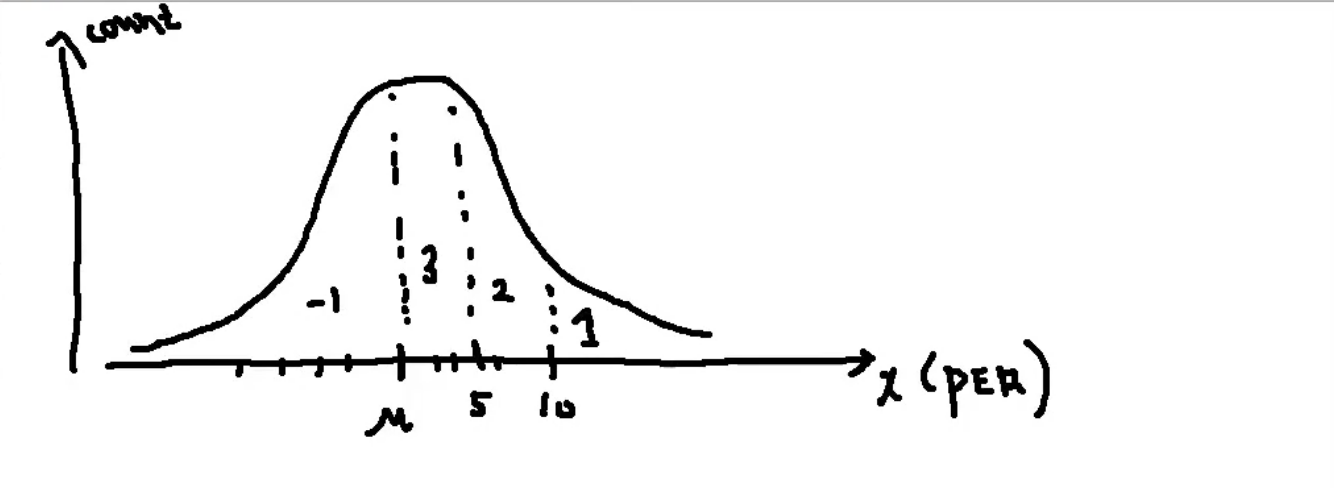 

- 곧 뒤에서 배울 `cut()` 을 사용하면 아래 방법보다 더 쉽게 가능

In [8]:
(df['PER(배)'] >= 10).head()

0     True
1     True
2    False
3     True
4     True
Name: PER(배), dtype: bool

In [9]:
bound1 = df['PER(배)'] >= 10
bound2 = (5 <= df['PER(배)']) & (df['PER(배)'] < 10)
bound3 = (0 <= df['PER(배)']) & (df['PER(배)'] < 5)
bound4 = df['PER(배)'] < 0

In [10]:
df.shape

(681, 17)

In [11]:
df[bound1].shape 
# = df.loc[bound1].shape
# loc 같은 경우에는 중요하다! get() operation 
# indexing 도 가능

(378, 17)

In [12]:
# 특정 조건을 만족하는 것에 대해서 새로운 데이터를 넣고 싶다고 할 때 
# 초보자의 경우 for 문으로 하나씩 체크하는 경우가 있음 
# 그러나 이는 벡터 연산이 가능....
# dataframe , series 에서 for 문을 사용하는 것은 좋은 코드라고 할 수 없다.
# 작업을 하면서 pandas 를 사용한다면 for 문을 사용하게 된다고 하면 
# 생각을 해야 한다. 
# df.loc[bound1, 'PER_Score'] = 1 
# 'PER_Score'는 없는 칼럼이기 때문에 조건 만족하는 로우들은 1로 채우고 나머지는 none 으로 
# 있는 칼럼을 사용하게 되면 해당 조건을 만족하면 그 값으로 대체 
df.loc[bound1, 'PER_Score'] = 1 
df.loc[bound2, 'PER_Score'] = 2 # 원본 데이터에 원하는 값을 채워 넣을 수 있다. 
df.loc[bound3, 'PER_Score'] = 3
df.loc[bound4, 'PER_Score'] = -1

In [13]:
df['PER_Score'].head()

0   1.000
1   1.000
2   2.000
3   1.000
4   1.000
Name: PER_Score, dtype: float64

In [14]:
df['PER_Score'].nunique() # 1,2,3, -1

4

In [15]:
df['PER_Score'].value_counts() 

1.000     378
2.000     148
-1.000    120
3.000      23
Name: PER_Score, dtype: int64

- `PER_Score`가 float number로 나오는 이유?

In [16]:
df['PER_Score'].hasnans # nanchecking
# 숫자형 series에서 none 이 있으면 
# int 형이라고 해도 float 으로 나오게 된다 🚀🚀
# 모든 숫자를 커버 함에도 외 nan이 나오는가?

True

In [17]:
df['PER_Score'].isna().sum()
# 12개의 nan이 있음
# 데이터를 받으면 nan 데이터가 있는지 없는지 확인하는 것이 중요하다. 
# df['PER(배)'] 이 처음부터 nan 값을 가지고 있어 바운드로 커버가 되지 않고
# false가 되는 경우가 있다. 

12

# nan 처리 방법
1. nan값이 들어 있는 행 없애 버리기
2. 다른 per 값들의 평균값으로 채우기 
3. -999 같은 특별한 값으로 채우기 


In [18]:
df['PER(배)'].isna().sum()

12

In [19]:
#null 인 경우의 값만 필터링을 한다. 
# 이 경우 크롤링 시 문제가 발생하거나 실제로 값이 nan인 경우가 있다.
# 이경우에는 다른 금융 api 값을 가져와서 하나씩 확인하는 방법이 있다. 
df[df['PER(배)'].isna()]

,ticker,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2,rtn,PER_Score
27,HSD엔진,8029.166,0.528,-22.571,-1812.265,-32.685,-13.120,2.749,-2607.575,7687.264,11552.757,nan,0.404,nan,2290.000,2569.000,0.122,nan
103,고려개발,6238.648,4.223,-4.895,-305.362,141.454,-4.903,20.462,-3118.716,1988.392,63716.438,nan,6.327,nan,12430.000,11659.000,-0.062,nan
126,까뮤이앤씨,1397.081,3.180,2.331,32.563,6.721,2.390,7.808,72.117,1153.474,3094.153,nan,0.958,nan,1105.000,1010.000,-0.086,nan
133,남영비비안,2074.953,-0.949,-1.103,-22.895,-1.667,-1.371,-2.101,-32.324,2031.729,3021.213,nan,0.436,nan,885.000,777.000,-0.122,nan
203,티탑스,940.880,-7.061,-4.217,-39.673,-8.980,-4.092,nan,-1917.146,19287.736,44614.258,nan,0.058,nan,1115.000,1575.000,0.413,nan
231,롯데칠성음료,22642.120,6.463,3.054,691.439,2.961,1.531,3.109,5107.448,172911.200,166829.270,nan,8.363,nan,145675.000,132900.000,-0.088,nan
371,쌍용양회공업,14302.892,18.027,12.243,1751.111,11.589,5.694,9.037,400.919,3627.562,3319.079,nan,0.816,nan,2960.000,3730.000,0.260,nan
507,컨버즈,459.748,-19.328,-35.526,-163.331,nan,nan,nan,-33811.426,20164.525,95172.870,nan,0.397,nan,4416.000,1750.000,-0.604,nan
560,풀무원,20306.730,1.869,0.491,99.778,6.765,0.979,1.933,4881.663,6986.189,533111.700,nan,2.011,nan,14050.000,17200.000,0.224,nan
622,한일철강,1112.614,5.475,4.236,47.131,3.405,1.467,4.510,249.431,8408.528,5453.988,nan,0.297,nan,2500.000,2645.000,0.058,nan


In [20]:
# nan 값을 0으로 메꾼다. 
# 기존에 데이터 값이 0인 것들이 있는지 확인해서 있다면 구분이 불가능하믕로 다른 값으로 
df.loc[df['PER_Score'].isna(), "PER_Score"] = 0

# 아래와 같은 방식으로도 가능
# df['PER_Score'] = df['PER_Score'].fillna(0) 
# df.loc[:, 'PER_Score'] = df['PER_Score'].fillna(0)

### boolean series 의 연산 특성 사용

간결하고 속도가 빠른 값을 찾아내는 아이디어로
항상 코드를 작성할 때 어떤 식으로 작성하는 것이 가장 최적인지 생각할 수 있어야 한다. 

In [21]:
# true 인 값만 1 * 1 로 1이 된다.
# 이런식으로 다 값을 구해서 더해주면 된다. 
df.loc[:, "PER_Score1"] = (bound1 * 1)  + (bound2 * 2) + (bound3 * 3) + (bound4 * -1) 

In [22]:
df['PER_Score1'].head()

0    1
1    1
2    2
3    1
4    1
Name: PER_Score1, dtype: int64

In [23]:
# integer가 부여되는 이유는 필터링으로 하는 것으로 했기 때문에
# nan 은 값이 부여되지 않았지만
#여기서는 값이 곱해졌기 때문에 nan 대신에 0이 대입된다. 
df['PER_Score1'].value_counts()

 1    378
 2    148
-1    120
 3     23
 0     12
Name: PER_Score1, dtype: int64

In [24]:
df['PER_Score'].value_counts()

1.000     378
2.000     148
-1.000    120
3.000      23
0.000      12
Name: PER_Score, dtype: int64

### 위의 두 score series는 서로 같을까? 

In [25]:
# equals 를 사용해야 nan이 있을 때 없을 때를 분석해 준다. 
df['PER_Score'].equals(df['PER_Score1'])

False

In [26]:
# per_score 값은 경우 float 였고,
# PER_Score1은 int
# 값이 아무리 같다고 해도 데이터형이 다르면 값이 다르다. 
df['PER_Score'].dtypes
df['PER_Score1'].dtypes

dtype('float64')

dtype('int64')

In [27]:
# int 형 타입으로 변환을 할 수가 있다. 
#df['PER_Score'].astype(int)
# 항상 새로운 방법을 찾을 때마다 equals로 확인을 한다. 
df['PER_Score'].astype(int).equals(df['PER_Score1'])

True

### `cut()`

In [28]:
# 구간을 리스트로 전달
# -np.inf  : 넘파이에서 제공하는 무한대를 표현하는 object 
# - 무한에서 ~ 0 | 0 ~ 5 | 5 ~ 10 | 10 ~ 무한대로 
# 영역을 나눈다


per_cuts = pd.cut(
    df['PER(배)'],
    [-np.inf, 0, 5, 10, np.inf], 
)

per_cuts.head()

0    (10.0, inf]
1    (10.0, inf]
2    (5.0, 10.0]
3    (10.0, inf]
4    (10.0, inf]
Name: PER(배), dtype: category
Categories (4, interval[float64]): [(-inf, 0.0] < (0.0, 5.0] < (5.0, 10.0] < (10.0, inf]]

category value : 정해진 유한개의 값만 가짐
'국적'이라는 변수는 대한민국, 미국, 중국 등의 유한개의 값을 ( 최대 지구에 존재하는 국가 수 ) 만 갖기 때문에 카테고리 변수

그러나 다른 예로 사람의 키는 170cm, 170.1cm 등 무한 개의 값을 가지기 때문에  카테고리 변수라고 보기 어렵다.

In [29]:
per_cuts.iloc[0]

Interval(10.0, inf, closed='right')

In [30]:
per_cuts.value_counts()

(10.0, inf]    378
(5.0, 10.0]    148
(-inf, 0.0]    120
(0.0, 5.0]      23
Name: PER(배), dtype: int64

In [31]:
per_cuts.isna().sum()

12

- cut()과 동시에 label 달아주기

해당 변수가 보기 좋은 것은 아니라 라벨을 붙임......

In [32]:
bins = [-np.inf, 10, 20, np.inf]
# 가치 기반 
labels = ['저평가주', '보통주', '고평가주']
per_cuts2 = pd.cut(
    df['PER(배)'], 
    bins=bins, 
    labels=labels
)
per_cuts2.head()

0     보통주
1    고평가주
2    저평가주
3     보통주
4    고평가주
Name: PER(배), dtype: category
Categories (3, object): ['저평가주' < '보통주' < '고평가주']

In [33]:
# 데이터를 df에 매핑 시키는 것
df.loc[:, 'PER_score2'] = per_cuts  # or per_cuts2
# df['PER_score2'] = per_cuts         # or per_cuts2

## Group내 데이터 갯수를 기준으로 grouping 하기 (SAME number of members in each  group)

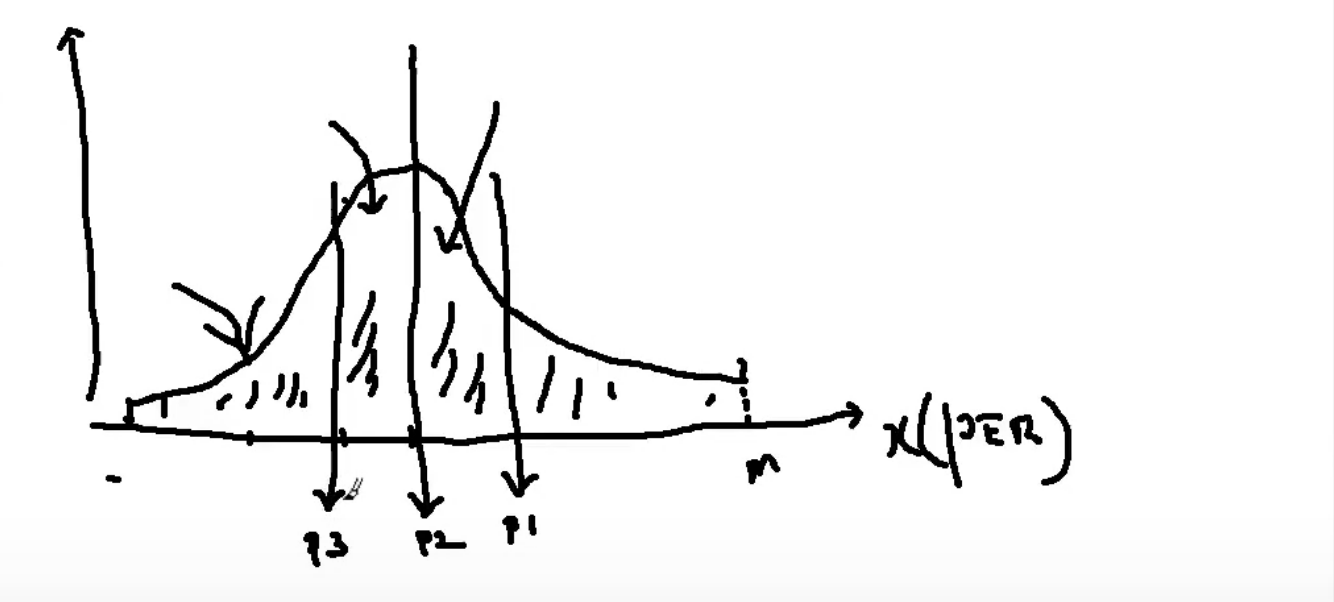

### `qcut()`

In [34]:
# qcut 그룹을 동일하게 나눈다
# 3개의 그룹으로 나눈다!
pd.qcut(df['PER(배)'], 3, labels=[1,2,3]).head()

0    2
1    3
2    1
3    3
4    3
Name: PER(배), dtype: category
Categories (3, int64): [1 < 2 < 3]

In [35]:
df.loc[:, 'PER_Score2'] = pd.qcut(df['PER(배)'], 10, labels=range(1, 11))
df.head()

,ticker,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2,rtn,PER_Score,PER_Score1,PER_score2,PER_Score2
0,AK홀딩스,29218.310,7.313,4.563,1333.223,12.193,5.091,15.515,5436.413,48112.402,220556.160,10.301,1.164,0.254,56000.000,68500.000,0.223,1.000,1,"(10.0, inf]",5
1,BGF,860.773,9.315,214.481,1846.192,21.624,10.433,8.015,3703.577,18648.623,1737.263,22.757,4.519,48.514,42140.000,15250.000,-0.638,1.000,1,"(10.0, inf]",8
2,BNK금융지주,49126.760,14.499,10.546,5181.144,7.919,0.564,nan,1568.237,20810.660,15358.993,5.535,0.417,0.565,8680.000,9420.000,0.085,2.000,2,"(5.0, 10.0]",3
3,BYC,2118.576,7.625,8.281,175.433,4.543,2.463,10.748,20872.312,471887.000,252211.450,19.020,0.841,1.574,397000.000,306000.000,-0.229,1.000,1,"(10.0, inf]",8
4,CJ,239541.970,5.230,2.379,5698.234,6.080,2.253,5.158,6257.152,114276.080,672045.900,28.181,1.543,0.262,176334.000,171148.000,-0.029,1.000,1,"(10.0, inf]",9


In [36]:
df['PER_Score2'].value_counts()

10    67
9     67
8     67
7     67
5     67
4     67
3     67
2     67
1     67
6     66
Name: PER_Score2, dtype: int64

In [37]:
#  항상 nan 처리에 유의하자
df['PER_Score2'].hasnans

True

In [38]:
df['PER_Score2'].isna().sum()

12

In [39]:
df['PER_Score2'].dtype

CategoricalDtype(categories=Noneordered=True)

CategoricalDtype
qcut에서 series로 메꾸었기 때문에 
1~10 까지 integer로 값을 채웠는데, 
사실 상 이것은 category 로 유한한 개수의 집합이어야 한다.
qcut은 10개라고 부여했기 때문에 CategoricalDtype로 
만약 nan을 -1 을 채우려고 한다면 오류가 난다. 이 때, CategoricalDtype로에 -1의 값이 없기 때문

< nan >
1. nan 랜덤 
2. per이 어디에 속해 있고, 유사하게 움직이는 섹터를 확인해서 해당 per을 사용하거나 
3. 그 섹터의 per 평균을 사용
4. nan 이 있는 경우 drop

- 'category' type: A string variable consisting of only a few different values

In [40]:
# DataFrame에서 category dtype인 columns들 추출하기
# df.select_dtypes(include=['category']).columns

In [41]:
df['PER_Score2'].head()

0    5
1    8
2    3
3    8
4    9
Name: PER_Score2, dtype: category
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

In [42]:
df['PER_Score2'].value_counts()

10    67
9     67
8     67
7     67
5     67
4     67
3     67
2     67
1     67
6     66
Name: PER_Score2, dtype: int64

In [43]:
# 'PER(배)' 의 nan이 있는 경우 drop
df = df.dropna(subset=['PER(배)'])
# df = df.dropna(subset=['PER_Score2']) 어차피 PER(배)로 PER_Score2가 nan이 되므로 같은 식

In [44]:
# nan value가 사라짐 
df['PER_Score2'].isna().sum()

0

# Split - Apply - Combine 

In [45]:
df = pd.read_csv("my_data/naver_finance/2016_12.csv")
df.shape

(681, 16)

In [46]:
df = df.dropna()
df.shape

(609, 16)

In [47]:
g_df = df.copy()
g_df.head()

,ticker,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2
0,AK홀딩스,29218.310,7.313,4.563,1333.223,12.193,5.091,15.515,5436.413,48112.402,220556.160,10.301,1.164,0.254,56000.000,68500.000
1,BGF,860.773,9.315,214.481,1846.192,21.624,10.433,8.015,3703.577,18648.623,1737.263,22.757,4.519,48.514,42140.000,15250.000
3,BYC,2118.576,7.625,8.281,175.433,4.543,2.463,10.748,20872.312,471887.000,252211.450,19.020,0.841,1.574,397000.000,306000.000
4,CJ,239541.970,5.230,2.379,5698.234,6.080,2.253,5.158,6257.152,114276.080,672045.900,28.181,1.543,0.262,176334.000,171148.000
5,CJ CGV,14322.454,4.911,0.393,56.217,3.105,0.284,2.919,583.051,17654.154,67682.260,120.744,3.988,1.040,70400.000,74200.000


## Group score 생성

In [48]:
g_df['rtn'] = g_df['price2'] / g_df['price'] - 1

In [49]:
g_df.loc[:, 'PER_score'] = pd.qcut(g_df['PER(배)'], 10, labels=range(1, 11))
g_df.loc[:, 'PBR_score'] = pd.qcut(g_df['PBR(배)'], 10, labels=range(1, 11))

In [50]:
g_df.set_index('ticker', inplace=True)

In [51]:
g_df.head()

,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2,rtn,PER_score,PBR_score
ticker,,,,,,,,,,,,,,,,,,
AK홀딩스,29218.310,7.313,4.563,1333.223,12.193,5.091,15.515,5436.413,48112.402,220556.160,10.301,1.164,0.254,56000.000,68500.000,0.223,5,7
BGF,860.773,9.315,214.481,1846.192,21.624,10.433,8.015,3703.577,18648.623,1737.263,22.757,4.519,48.514,42140.000,15250.000,-0.638,8,10
BYC,2118.576,7.625,8.281,175.433,4.543,2.463,10.748,20872.312,471887.000,252211.450,19.020,0.841,1.574,397000.000,306000.000,-0.229,8,5
CJ,239541.970,5.230,2.379,5698.234,6.080,2.253,5.158,6257.152,114276.080,672045.900,28.181,1.543,0.262,176334.000,171148.000,-0.029,9,8
CJ CGV,14322.454,4.911,0.393,56.217,3.105,0.284,2.919,583.051,17654.154,67682.260,120.744,3.988,1.040,70400.000,74200.000,0.054,10,10


In [52]:
g_df.get_dtype_counts()

AttributeError: 'DataFrame' object has no attribute 'get_dtype_counts'

## groupby() & aggregation

- `groupby()`
    - 실제로 grouping까지는 하지 않고, grouping이 가능한지 validation만 진행(preparation)
- Aggregation
    - 2가지 요소로 구성
        - aggregating columns
        - aggregating functions
            - e.g. `sum, min, max, mean, count, variacne, std` etc

- 결국, 3가지 요소만 충족시키면 됨!
    - Grouping columns (cateogorial data type)
    - Aggregating columns
    - Aggregating functions

### `groupby` object 살펴보기

In [ ]:
g_df.groupby('PER_score')

In [ ]:
g_df_obj = g_df.groupby(["PBR_score", "PER_score"])
g_df_obj

In [ ]:
type(g_df_obj)

In [ ]:
g_df_obj.ngroups

In [ ]:
g_df['PBR_score'].nunique()
g_df['PER_score'].nunique()

- "ngroups와 (g_df['PBR_score'].nunique() x g_df['PER_score'].nunique())가 차이가 나는 이유"에 대해서 생각해보기

In [ ]:
type(g_df_obj.size())

In [ ]:
g_df_obj.size().head()

In [ ]:
# Multi-level index를 가진 Series indexing하는 법 
g_df_obj.size().loc[1]
g_df_obj.size().loc[(1, 1)]

In [ ]:
# Series -> DataFrame으로 변환
g_df_obj.size().to_frame().head()

In [ ]:
type(g_df_obj.groups)
g_df_obj.groups.keys()
g_df_obj.groups.values ()

In [ ]:
# Retrieve specific group
g_df_obj.get_group((1, 1))

- For loop을 이용해서 grouping된 object 확인해보기 (많이는 안쓰임)

In [ ]:
for name, group in g_df_obj:
    print(name)
    group.head(2)
    break

In [ ]:
# 참고 :groupby()에 대해 head()를 적용하면, 기존이 head()가 작동하는 방식, 즉, 최상위 2개를 가지고 오는게 아니라
# 각 그룹별 최상위 2개를 무작위로 섞어서 하나로 합친 DataFrame을 리턴함
g_df.groupby('PER_score').head(2)

### aggreggation

- 반드시 "aggregating" 기능이 있는 function 을 써야함
    - min, max, mean, median, sum, var, size, nunique, idxmax

In [ ]:
g_df.groupby("PBR_score").agg(
    {
        "rtn": "mean", # =  np.mean
    }
)

In [ ]:
pbr_rtn_df = g_df.groupby("PBR_score").agg({'rtn': 'mean'})
per_rtn_df = g_df.groupby("PER_score").agg({'rtn': 'mean'})

In [ ]:
pbr_rtn_df.head()

In [ ]:
# 다양한 방법으로 진행하기 (같은 결과)
g_df.groupby("PER_score")['rtn'].agg('mean').head()
g_df.groupby("PER_score")['rtn'].agg(np.mean).head()
g_df.groupby("PER_score")['rtn'].mean().head()

In [ ]:
# return type이 다를 수 있음에 주의
g_df.groupby("PER_score")['rtn'].agg("mean").head(2)   # Series로 return
g_df.groupby("PER_score")[['rtn']].agg("mean").head(2)  # DataFrame으로 return

In [ ]:
# 2개 이상의 컬럼에 대해 aggregation
g_df.groupby("PER_score")[['rtn', 'PBR(배)']].agg("mean").head(2)

In [ ]:
# 2개 이상의 aggregation
g_df.groupby("PER_score")[['rtn', 'PBR(배)']].agg(["mean", "std"]).head(2)

In [ ]:
# 2개 이상의 컬럼 & 각각에 대해 다른 aggregation
g_df.groupby("PBR_score").agg(
    {
        'rtn': ['mean', 'std'],
        'PER(배)': ['min']
        
    }
)

- aggregation function이 아닌경우 => `agg()`가 error를 발생시킴


In [ ]:
# sqrt는 aggregation 방식의 연산이 아님!
np.sqrt([1, 2, 3, 4])

In [ ]:
g_df.groupby("PER_score")['rtn'].agg(np.sqrt)

- Visualization(시각화) 맛보기

In [ ]:
%matplotlib inline

In [ ]:
pbr_rtn_df.plot(kind='bar')

In [ ]:
pbr_rtn_df.plot(kind='bar');
per_rtn_df.plot(kind='bar');

### Examples

In [ ]:
g_df1 = g_df.groupby(["PBR_score", "PER_score"])\
            .agg(
                {
                    'rtn': ['mean', 'std', 'min', 'max'],
                    'ROE(%)': [np.mean, 'size', 'nunique', 'idxmax'] 
                 }
            )
g_df1.head()

In [ ]:
a = g_df.groupby(["PBR_score", "PER_score"])['rtn', 'ROE(%)'].agg(['sum', 'mean'])

In [ ]:
# Multi-index라고 해서 쫄 것 없음!
a.loc[1]
a.loc[(1, 3)]
a.loc[[(1, 3), (1, 4 )]]

### 주의: nan은 groupby시 자동으로 filter out 되기 때문에, 미리 전처리 다 하는게 좋음 

In [ ]:
df = pd.DataFrame({
    'a':['소형주', np.nan, '대형주', '대형주'],
    'b':[np.nan, 2,         3,     np.nan],
})
df

In [ ]:
df.groupby(['a'])['b'].mean()

###  `as_index = False` : group cols들이 index가 아니라 하나의 col이 됨 (aggregate하고 reset_index()를 취한 것)

In [ ]:
a = g_df.groupby(["PER_score"]                ).agg({'rtn': ['mean', 'std']}).head(2)
b = g_df.groupby(["PER_score"], as_index=False).agg({'rtn': ['mean', 'std']}).head(2)

In [ ]:
a
b

In [ ]:
a.index
a.columns

In [ ]:
b.index
b.columns

In [ ]:
a['rtn']

In [ ]:
a[('rtn', 'mean')].head()

### Multi-index columns을 하나로 병합하기

In [ ]:
g_df1.head()

In [ ]:
level0 = g_df1.columns.get_level_values(0)
level1 = g_df1.columns.get_level_values(1)

level0
level1

In [ ]:
g_df1.columns = level0 + '_' + level1

In [ ]:
g_df1.head(2)

In [ ]:
g_df1 = g_df1.reset_index()
g_df1.head()

# 실전예제: 시가총액으로 Small and Big 나누기 

In [ ]:
a_df = pd.read_csv("my_data/Small_and_Big.csv", index_col=[0])
a_df.head()

In [ ]:
a_df.tail()

In [ ]:
median_df = a_df.groupby(['date']).agg({'시가총액 (보통)(평균)(원)': 'median'})
median_df.head()

In [ ]:
median_df.columns = ['시가총액_median']
median_df.head()

- 구한 median dataframe을 어떻게 가존의 원본 dataframe과 연결 시킬수있을까?
=> 다음 노트북!